# Autoencoders

#### Ich habe meine bestes gegeben, die Trainingszeit zuminimieren. In dem ich ein bereits trainiertes Model gespeichter habe. Allerdings spielt der Server da nicht mit. Deswegn am besten beim Training einfach eine Stunde was anderes machen. Ihr müsst auchj nicht 100 Epochs trainieren sondern könnte über Kernel > Interupt Kernel das Training frühzeitig beenden.
---
**Lernziele**

- Sie verstehen das Konzept eines Autoencoders
- Sie verstehen wie ein RNN Smiles generieren kann
- Sie können ein Netzwerk auch als PyTorch Klasse definieren
- Sie verstehen die Bedeutung der `<sos>`/`<eos>` Token 
---
Im heutigen Notebook beschäftigen wir uns mit den sogenannten **Autoencodern**.
Autoencoder werden meisten in durch Selfsupervised Training trainiert.
Als Erinnerung, Selfsupervised Training bezeichnet das Training von neuronalen Netzwerke, bei dem der Input und Output identisch sind. Das Ziel ist es also den Input wiederherzustellen. 

Doch welchen Mehrwert hat es ein Netzwerk, welches nur den Input wiederherstellt.
Tatsächlich interessieren wir uns nicht unbedingt für den Output eines Autoencoder. Uns interessiert mehr, was in der Mitte des Netzwerkes passiert. 
Denn das eigentliche Ziel von Autoencodern ist, die Daten zu komprimieren, also möglichst effektiv darzustellen.

Im Beispielbild wird zum Beispiel ein Autoencoder für Bilder dargestellt:

<img src="https://d3i71xaburhd42.cloudfront.net/b1786e74e233ac21f503f59d03f6af19a3699024/2-Figure1-1.png" >

*Yifei Zhang - A Better Autoencoder for Image: Convolutional Autoencoder * **2018**

Ein Autoencoder besteht aus zwei Netzwerken, einem **Encoder** und einem **Decoder**. Der Output des Encoder wird als Input für den Decoder genutzt. Der Encoder soll lernen, möglichst effektiv,  die Daten in einem niedrig dimensionalen Raum (latent Space) darzustellen. Diese Darstellung ist in der Regel einfach ein Vektor, welcher auch als **latent Vector** beschrieben wird. Der Deocder wird trainiert, um anhand dieses latent Vectors den originalen Input wieder herzustellen. 

Wir können selber bestimmen, wie groß der latent Vector werden soll. Meistens wird eine besonders kleine Größe gewählt, um eine größere Kompression zu gewährleisten.
Nach erfolgreichem Training sollte der *latent Vector*, trotz seiner geringen Größe, genug Information enthalten, um das Bild vollständig wieder auszugeben. Das bedeutet, dass dieser Vector ausreichend informativ ist, um das komplette Bild zu beschreiben. Tatsächliche Anwendungen gehen über die einfach Rekonstruktion hinaus.

Zum Beispiel werden Autoencoder benutzt und die Qualität von Bilder zu verbessern. Hierfür werden als Input niedrig auflösende Bilder benutzt und der Output ist dasselbe Bild in seiner regulären (höher) Auflösung. So werden Netzwerke trainiert, die später schlecht aufgelöste Bilder schärfen können. 


<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60bcd0b7b750bae1a953d61d_autoencoder.png" width ="400px">

*Hmrishav Bandyopadhyay - An Introduction to Autoencoders: Everything You Need to Know* **2021**

Autoencoder gibt es aber nicht nur für Bilder, sondern auch für Text. Hierfür werden RNNs verwedent. 
Im letztes Notebook haben wir bereits besprochen, dass der letzte Hidden State eines Recurrent Neural Netzwerk ein Zusammenfassung der gesamten Inputsequenz ist. In dem Besipeil der Hidden State $O_5$

<img src="https://miro.medium.com/max/724/1*1U8H9EZiDqfylJU7Im23Ag.gif">

*Michael Phi - An illustrated Guide to Recurrent Neural Networks*

Der Output $O_5$ ist quasi schon eine kompremierete Version unseres Satzes. Der Hidden State $O5$ ist also der latent Vector der unseren Satz beschreibt. Dementsprechend ist auch das Netzwerk, das diesen Vektor erzeugt hat unsere Encoder. Für unseren Autoencoder fehlt nur noch der Decoder, der den originalen Satz aus dem latent Vector wieder herstellen kann. Wie das genau funktiert besprechen wir an Hand eines Beispiel mit Smiles.

In [2]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit import RDLogger  
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
RDLogger.DisableLog('rdApp.*')      
%run ../utils/utils.py

Diese Woche benutzen wir einen Datensatz der Firma Enamine. Und zwar die [High Fidelity Fragment Library](https://enamine.net/compound-libraries/fragment-libraries/high-fidelity-library). Dieser Datensatz besteht aus Fragmenten, die, aufgrund ihrer physikochemischen Eigenschaften, sich besonders gut für den Bereich MedChem eignen. Für uns ist vor allem wichtig, dass die Moleküle nicht zu groß werden. Denn aus dem Latent Vector einen validen Smiles zu kreieren ist schwierig . Je länger der Smiles wird, desto komplexer wird die Aufgabe für das Netzwerk.

Diese Woche kommen die Moleküle auch in einem anderen Dateiformat. Der `.sdf` Format speichert die Moleküle mit mehr Detail. So können hier z.B. auch Informationen zu der Konformation gespeichert werden. 

Ein einzelnes Molekül wird wie folgt dargestellt:
```

  Mrv0541 07182119162D          

 12 12  0  0  0  0            999 V2000
    0.7145    2.0625    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145    1.2375    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289    0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.1434   -0.4125    0.0000 F   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -0.4125    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7145   -1.2375    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4289   -1.6500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.6500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7145   -0.4125    0.0000 F   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    0.8250    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0  0  0  0
  2  3  4  0  0  0  0
  3  4  4  0  0  0  0
  4  5  1  0  0  0  0
  4  6  4  0  0  0  0
  6  7  1  0  0  0  0
  7  8  2  0  0  0  0
  7  9  1  0  0  0  0
  6 10  4  0  0  0  0
 10 11  1  0  0  0  0
 10 12  4  0  0  0  0
  2 12  4  0  0  0  0
M  END
>  <Catalog ID>
Z1255462241

>  <PlateID>
1225133-R3-01

>  <Well>
A02

>  <MW (desalted)>
172.129

>  <CLogP>
2.082

>  <HBD>
1

>  <TPSA>
37.300

>  <RotBonds>
1

```
Sie sehen auch zusätzliche Informationen wie TPSA oder LogP können gleich mit gespeichert werden.

Um so eine `.sdf` Datei in Python einzulesen brauchen wir einen sogenannten `MolSupplier` von `rdkit`. Ein Supplier stellt die Verbindung zwischen unsere Datein und Python her. Mit einem `for-loop` können dann die einzelnen Smiles aus dem SDF-File generiert werden.

In [3]:
suppl = Chem.SDMolSupplier("../data/high_fidelity/Enamine_High_Fidelity_Fragment_Library_plated_1920cmds_20210718.sdf")

In [4]:
smiles = []
for mol in suppl:
    smiles.append(Chem.MolToSmiles(mol)) 
smiles[:10]

['Cc1cc(F)c(C(=O)O)c(F)c1',
 'O=C1CC(CO)(c2ccccc2)CN1',
 'O=C1CCC(C(=O)O)(c2ccccc2)CN1',
 'C1COC2CCNCC2C1',
 'CC1(C)CCCCC1C(=O)O',
 'Nc1cc(C(F)(F)F)no1',
 'COC1(C)CC(N)C1(C)C',
 'Cn1nc(C2CC2)cc1N',
 'O=C(O)c1cnoc1C1CC1',
 'O=C1CC2(Cc3ccccc3C2)C(=O)N1']

Sie sehen, auch so können wir Smiles aus den `.sdf` Dateien generieren. Auch können wir uns die Strukturen einmal anzeigen lassen, um ein besseres Gefühl für die Art von Fragmenten zu bekommen.

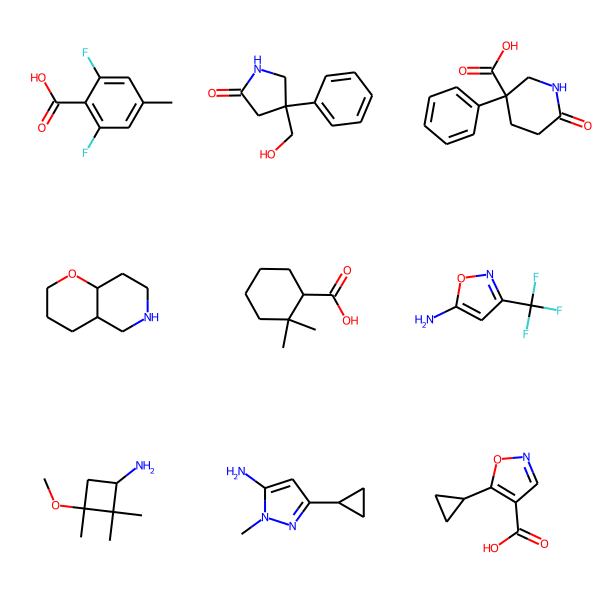

In [5]:
MolsToGridImage([Chem.MolFromSmiles(x)for x in smiles[:9]])

In [6]:
len(smiles)

1920

Insgesamt haben wir 1920 Moleküle im Datensatz.

Wenn Sie sich die Smiles genau anschauen fällt Ihnen etwas auf?

In [7]:
smiles

['Cc1cc(F)c(C(=O)O)c(F)c1',
 'O=C1CC(CO)(c2ccccc2)CN1',
 'O=C1CCC(C(=O)O)(c2ccccc2)CN1',
 'C1COC2CCNCC2C1',
 'CC1(C)CCCCC1C(=O)O',
 'Nc1cc(C(F)(F)F)no1',
 'COC1(C)CC(N)C1(C)C',
 'Cn1nc(C2CC2)cc1N',
 'O=C(O)c1cnoc1C1CC1',
 'O=C1CC2(Cc3ccccc3C2)C(=O)N1',
 'O=C(O)CN1CCc2ccccc2C1=O',
 'Cn1ncc2cc(CC(=O)O)ccc21',
 'CCC(N)C1CCOCC1',
 'NC(=O)c1cccc(CO)c1',
 'Cc1nn(C)c(C)c1C1COCCN1',
 'Fc1ccc(C2CNCCO2)cc1Cl',
 'Nc1nc(C(F)(F)F)ns1',
 'OCc1nc(-c2ccc(F)cc2)no1',
 'OC1(C2CC2)CCNCC1',
 'O=C(O)c1cncc(F)c1',
 'CCNCc1cn(C)nn1',
 'O=C(O)c1cccc(C2CCCOC2)c1',
 'OCc1ccc(-c2c[nH]cn2)cc1',
 'OCc1nc2ccc(F)cc2o1',
 'O=C(CCc1ccccc1)N1CCNCC1',
 'CC1CCCN(C(=O)CO)C1',
 'Cl.Cl.NCc1cccc(-n2ccnc2)c1',
 'CC1Cc2ccc(F)cc2C1N.Cl',
 'Cl.NC1CCCc2cc(F)ccc21',
 'CC1CN(c2ccc(CN)cc2)S(=O)(=O)C1',
 'OC1(c2ccccc2)CCCC1',
 'Nc1nc(C(F)(F)F)co1',
 'c1cnc2c(c1)NCCN2',
 'CN1CCN(C(=O)C2CCCO2)CC1',
 'O=C(O)C1CC12CCOC2',
 'O=S1(=O)CC(c2ccc(F)cc2)CN1',
 'CC1Oc2c(F)cccc2C1N.Cl',
 'CC1c2ccccc2CC1O',
 'NS(=O)(=O)c1cnc2ccc(F)cc2c1',
 'CNc1cc

Ein Problem ist, dass noch Stereoinformation in den Smiles enthalten sind. Zum Beispiel das `@` Symbol. Ein weiteres Problem ist der `.`. Dieser markiert den Beginn eines weiteren Moleküls. In unserem Fall sind es aber eigentlich nur `Cl` Atome, die noch in manchen Smiles sind. 
Zum Beispiel Moleküle 27.

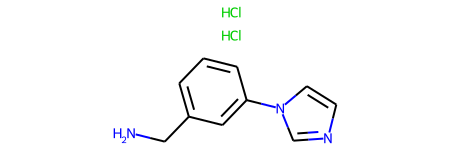

In [8]:
Chem.MolFromSmiles(smiles[26])

Wir können sowohl Stereoinformation, als auch die "extra" Moleküle mit  Stringmanipulationen entfernen.

`string.replace("@", "")`

sucht im `string` nach dem Zeichen `@` und falls es welche findet werden sie mit `""` ersetzt. Also einfach gelöscht.

`string.split(".")`

teilt den `string` bei jedem `"."`. Die Funktion gibt die einzelnen Substrings als Liste aus.

In [9]:
"Schoko.l@de".replace("@", "").split(".")

['Schoko', 'lde']

In [10]:
sub_molecules = []
for smile in smiles:
    smile = smile.replace("@", "")
    smile = smile.replace("\\", "")
    sub_molecules.append(smile.split("."))

Im nächsten Schritte müssen wir nur noch durch die Moleküllisten durch iterieren. Wenn ein Smiles aus mehreren Molekülen bestand, wählen wir einfach das größte Molekül als das richtige aus.

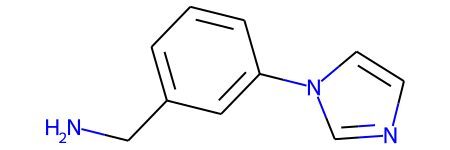

In [11]:
filtered_smiles =[]
for mol_list in sub_molecules:
    filtered_smiles.append(mol_list[np.argmax([len(x) for x in mol_list])])
    
Chem.MolFromSmiles(filtered_smiles[26])

Das 27 Moleküle hat jetzt nicht mehr die zusätzlichen `HCl`s.

Die Smiles sind jetzt "sauber" und wir können beginnen sie für das RNN aufzubereiten. Also einen Dictionary zu erstellen und die Smiles durch Tokens zu ersetzen. Zunächst benutzen wir wieder die `creat_dict` Funktion, um einen Dictionary für unsere Daten zu erstellen. Doch diesmal benutzten wir auch den Parameter `add_tokens = True`:

In [12]:
dictionary = create_dict(filtered_smiles, add_tokens =True)
dictionary

{'<sos>': 0,
 '<eos>': 1,
 '<pad>': 2,
 ')': 3,
 'O': 4,
 '1': 5,
 'C': 6,
 '=': 7,
 '(': 8,
 'F': 9,
 'c': 10,
 '2': 11,
 'N': 12,
 'n': 13,
 'o': 14,
 '3': 15,
 'Cl': 16,
 's': 17,
 '-': 18,
 ']': 19,
 'H': 20,
 '[': 21,
 'S': 22,
 '#': 23,
 'P': 24}

Es wurden 3 Tokens hinzugefügt, die nicht in den Smiles vorkommen.

- `<pad>` kennen Sie bereits, dieser wird benutzt, um alle Smiles auf dieselbe Länge zu bekommen.

- `<sos>` ist ein Token, der den Anfang eines Smiles ankündigt. "Start of Sentence". Dieser Token wird **vor** jeden Smiles gestellt.

- `<eos>` kündigt das Ende des Smiles an. Nachdem der eigentliche Smiles zu Ende ist foglt der `<eos>` Token und dann die Paddingtokens

Unsere Smiles sollen also wie folgt aussehen:

```python
"<sos>OCc1ccc2occc2c1<eos><pad><pad>"
```


<img src="Img/rnn/auto_4.png" width ="400px">
Warum ist das nötig? Wieso werden diese besonderen Tokens benötigt?

Das liegt daran, wie ein Decoder für ein RNN funktioniert. 

Nochmal als Erinnerung, so sieht unser Model aus:

<img src="Img/rnn/auto_1.png" width ="400px">

Den Encoder haben wir quasi letzte Woche geschrieben, wir müssen uns nur noch auf den Decoder konzentrieren.
Die Grundidee eines Decoder RNN ist es, dass der SMILES Token für Token hintereinander generiert.

Ein Beispiel:

Der Decoder bekommt den latent Vector vom Encoder:
Darauf generiert ein `C`. Jetzt kann der Decoder mithilfe des Latent Vector und dem bereits generierten `C` ein weiteres `C` generieren. Darauf hin ist unsere momentane SMILES `CC`. Jetzt wiederholt sich der Schritt wieder, mit dem Wissen vom latent Vector und den bereits zwei `CC`.
Mit dem Wissen kann der Decoder jetzt z.B. ein `=` generieren: `CC=` usw...
Theoretisch könnte das unendlich so weiter gehen. Deswegen gibt es einen `<eos>` Token. Dieser erlaubt es dem Netzwerk den Smiles zu beenden, wenn es denkt dieser ist komplett.

Ein bisschen theoretischer wird es im Folgenden:

Um es genauer zu verstehen, wiederholen wir noch einmal schnell wie ein RNN funktioniert.

Ein RNN hat immer zwei Inputs. Einmal den normalen Input, also der momentane Token (Smiles Symbol) für den es eine Vorhersage zu machen gilt.
Zusätzlich wird ein Hidden State vom vorherigen Schritt genommen. Also der Output des RNNs für den vorherigen Token.

Durch den Encoder erhalten wir schon den latent Vektor, welcher unser initialer Hidden State sein wird. 
<img src="Img/rnn/auto_3.png" width ="400px">

Doch was ist unser initialer Input?

<img src="Img/rnn/auto_4.png" width ="400px">

Das Problem ist, wenn wir den tatsächlich ersten Token des originalen Smiles als ersten Token für das Netzwerk verwenden, ist es relativ leicht diesen richtig zu vorhersagen. Deswegen benutzen wir zunächst den `<sos>` Token. Dieser enthält nämlich keine Informationen über den Smiles. Das heißt, der erste Token wird nur auf Basis des Hidden States bzw. der latent Vectors vorhergesagt. Wichtig ist auch das der Output des RNN (der neue Hidden State) erst noch durch eine Linear Layer geführt wird, die den richtigen Token vorhersagt.
<img src="Img\rnn\auto_6.png" width ="400px">

Im nächsten Schritt, ersetzt der neue Hidden State den latent Vector, als Input für den nächsten Schritt. Auch wird jetzt nicht mehr ein Token des originalen Smiles als Input benutzt, sondern der Token, der im vorangegangen Schritt vorhergesagt worden ist. 
Das heißt, auch wenn der Decoder am Anfang einen Fehler macht, dann rechnet er auch mit diesem Fehler weiter.
<img src="Img\rnn\auto_7.png" width ="400px">


Wir wiederholen, dass so lange bis wir die Länge des längsten Smiles in unserm Datensatz erreicht haben. Natürlich sind die meisten Smiles nicht so lange, deswegen können wir den `<eos>` gebrauchen. Mit dem kann der Smiles schon vorher als fertig erkannt werden. 
<img src="Img/rnn/auto_8.png" width ="400px">

Wenn wir in der Funktion `tokenize` ` (..., add_tokens=True)` benutzen werden automatisch die `<sos>` und `<eos` zu jedem Smiles hinzugefügt. Das ist die `0` die im `dictionary` für `<sos>` steht und die `1` für `<eos>`.

In [13]:
tokenized_smiles = tokenize(filtered_smiles,dictionary, add_tokens =True)
tokenized_smiles[0]

[0,
 6,
 10,
 5,
 10,
 10,
 8,
 9,
 3,
 10,
 8,
 6,
 8,
 7,
 4,
 3,
 4,
 3,
 10,
 8,
 9,
 3,
 10,
 5,
 1]

Noch sind die Smiles alle unterschiedlich lang. Wir berechnen zu nächst die Anzahl der Tokens in jedem Smiles.

In [14]:
token_lengths = np.array([len(x) for x in tokenized_smiles])
max_length=max(token_lengths)
max_length

36

Wir können die Anzahl der Tokens auch mit einem Histogramm darstellen. Das Problem ist nämlich, dass je mehr Tokens ein Smiles hat, desto schwieriger wird es für den Decoder den kompletten Smiles zu entschlüsseln.

(array([  1.,  22.,   9.,  97.,  89., 126., 169., 210., 178., 161., 176.,
        138.,   0., 141., 112.,  98.,  70.,  53.,  33.,  15.,  10.,   9.,
          1.,   1.,   1.]),
 array([13.  , 13.92, 14.84, 15.76, 16.68, 17.6 , 18.52, 19.44, 20.36,
        21.28, 22.2 , 23.12, 24.04, 24.96, 25.88, 26.8 , 27.72, 28.64,
        29.56, 30.48, 31.4 , 32.32, 33.24, 34.16, 35.08, 36.  ]),
 <BarContainer object of 25 artists>)

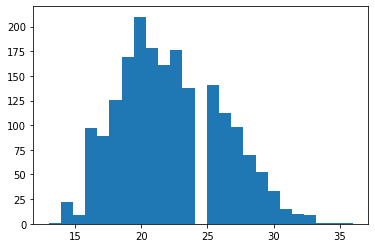

In [15]:
plt.hist(token_lengths, bins=25)

Zum Beispiel könnten wir alle Moleküle aus dem Datensatz werfen, die aus mehr 26 Tokens bestehen.

In [16]:
np.sum(token_lengths>26)

291

Das sind genau 291 Moleküle. Das ist natürlich nicht ideal, aber hilt uns im Training. gerade mit so wenig Daten ist es schwierig ein Autoencoder zu trainieren. Wir werfen diese großen Moleküle zunächst aus dem Datensatz. 

In [17]:
filtered_smiles=np.array(filtered_smiles)[token_lengths<=26].tolist()
len(filtered_smiles)

1629

Mit den reduzierten Daten erstellen wir einen neuen Dictionary und tokenizen unsere Daten.

In [18]:
dictionary = create_dict(filtered_smiles, add_tokens =True)
tokenized_smiles = tokenize(filtered_smiles,dictionary, add_tokens =True)
tokenized_smiles[:5]

[[0,
  6,
  10,
  5,
  10,
  10,
  8,
  9,
  3,
  10,
  8,
  6,
  8,
  7,
  4,
  3,
  4,
  3,
  10,
  8,
  9,
  3,
  10,
  5,
  1],
 [0,
  4,
  7,
  6,
  5,
  6,
  6,
  8,
  6,
  4,
  3,
  8,
  10,
  11,
  10,
  10,
  10,
  10,
  10,
  11,
  3,
  6,
  12,
  5,
  1],
 [0, 6, 5, 6, 4, 6, 11, 6, 6, 12, 6, 6, 11, 6, 5, 1],
 [0, 6, 6, 5, 8, 6, 3, 6, 6, 6, 6, 6, 5, 6, 8, 7, 4, 3, 4, 1],
 [0, 12, 10, 5, 10, 10, 8, 6, 8, 9, 3, 8, 9, 3, 9, 3, 13, 14, 5, 1]]

In [19]:
token_lengths = np.array([len(x) for x in tokenized_smiles])
max_length=max(token_lengths)
max_length

26

Alle unsere Smiles bestehen jetzt aus maximal 26 Tokens. Als letzten Schritt müssen wir noch die Smiles die nicht aus 26 Tokens bestehen auf die richtige Länge bringen. Dazu benutzen wir den `<pad>` Token.

In [20]:
for i, tok_smi in enumerate(tokenized_smiles):
    tokenized_smiles[i] = tok_smi+ [dictionary["<pad>"]]*(max_length - token_lengths[i])

Im letzten Schritt konvertieren, wir die Listen von Tokens zu einem Tensor.

In [21]:
tokenized_smiles=torch.tensor(tokenized_smiles, dtype=torch.long)
tokenized_smiles[:5]

tensor([[ 0,  6, 10,  5, 10, 10,  8,  9,  3, 10,  8,  6,  8,  7,  4,  3,  4,  3,
         10,  8,  9,  3, 10,  5,  1,  2],
        [ 0,  4,  7,  6,  5,  6,  6,  8,  6,  4,  3,  8, 10, 11, 10, 10, 10, 10,
         10, 11,  3,  6, 12,  5,  1,  2],
        [ 0,  6,  5,  6,  4,  6, 11,  6,  6, 12,  6,  6, 11,  6,  5,  1,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2],
        [ 0,  6,  6,  5,  8,  6,  3,  6,  6,  6,  6,  6,  5,  6,  8,  7,  4,  3,
          4,  1,  2,  2,  2,  2,  2,  2],
        [ 0, 12, 10,  5, 10, 10,  8,  6,  8,  9,  3,  8,  9,  3,  9,  3, 13, 14,
          5,  1,  2,  2,  2,  2,  2,  2]])

## Model

Heute werden wir das erstmal nicht `nn.Sequential` benutzen, um unsere Model zu erstellen. Bei einfache Architekturen, bietet sich  `nn.Sequential` an, dass es schnell zu definieren ist. Allerdings ist es nicht sehr flexibel. 
Deswegen werden meisten Netzwerke mit PyTorch "von Hand" geschrieben.

Wie das geht, schauen wir uns heute an:

Zwei Prozesse muss ein Netzwerk in PyTorch erledigen:

1. Es muss die nötigen Weights initialisieren 
2. Es muss den Input durch das Netzwerk führen

Das Initialisieren bei `nn.Sequential()` wird beim `model` erstellen automatisch gemacht.

In [22]:
model = nn.Sequential(nn.Linear(10,20), nn.ReLU(), nn.Dropout(0.2), nn.Linear(20,1))
model 

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=20, out_features=1, bias=True)
)

In [23]:
list(model.parameters())[1]

Parameter containing:
tensor([ 0.1589, -0.0070,  0.2799,  0.0982, -0.2169,  0.0608,  0.0074, -0.1634,
        -0.2114, -0.2419, -0.0717, -0.1254, -0.1585,  0.3098,  0.0871, -0.2200,
        -0.0302,  0.2415, -0.0760,  0.3010], requires_grad=True)

So haben wir bis jetzt unsere Netzwerke definiert. Jede Layer wird automatisch
`model = nn.Sequential(nn.Linear(10,20), nn.ReLU(), nn.Dropout(0.2), nn.Linear(20,1))` durch diesen Schritt erstellt und die Weight zufällig initialisiert.

Wir können, aber auch unser eigenes Netzwerk selber definieren.
Dafür müssen wir ein PyTorch Klasse erstellen. Klassen in Python ähneln ein wenig Funktionen. Nur können Klassen auch Eigenschaften und eigene Funktionen enthalten. Auf die genauen Funktionen von Klassen werden wir hier nicht ein gehen.

Wichtig ist, dass wir auch Klassen erstellen können, die sich wie PyTorch Klassen verhalten.
Dafür schreiben wir zunächst folgenden Code:

``` python
class einfaches_nn(nn.Module):
```

Damit legen wir fest, dass die Klasse `einfaches_nn` eine Klasse, die zu `nn.Module` gehört. Also wie andere Layer oder Modelle in PyTorch zu `nn` gehören soll.

Als Nächstes folgt die Initialisierung 

``` python
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
```

`def __init__(self,input_dim, hid_dim, out_dim, dropout):` ist eine Funktion, die beim Initialisieren des Netzwerkes aufgerufen werden soll. Wichtig ist, dass neben den Dimensionen, die die Größe des Netzwerkes festlegen, auch ein `self` als Input aufgeführt ist.

`self` "enthält" alle Informationen, die für diese Klasse gespeichert werden. Diese können auch über die Funktion hinaus benutzt werden. Das sollte in ein paar Minuten deutlicher werden.

`super().__init__()` ist Teil des Codes der wichtig für PyTorch Klassen ist. Dieser Teil darf nicht in der Initialisierung fehlen.

Als Nächstes können wir unsere linear Layers und Dropout in `self` "speichern":

``` python
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
```

`self.ln1 = nn.Linear(input_dim, hid_dim)` erlaubt es uns, später in andere Funktionen die erste linear Layer mit `self.ln1` auszuwählen

In [24]:
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

In [25]:
model_2 = einfaches_nn(input_dim=10,hid_dim= 20, out_dim=1, dropout=0.2)
model_2

einfaches_nn(
  (ln1): Linear(in_features=10, out_features=20, bias=True)
  (ln2): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Wir können sehen, dass das Netzwerk auch aus den richtigen Layers besteht, aber in falscher Reihenfolge. Außerdem fehlt die ReLU Funktion. Das ist bis jetzt auch nicht weiter schlimm, denn die `__init__` Funktion soll ja nur das Model initialisieren, also erst einmal nur die Layers und deren Weights kreieren. ReLU hat keine Weights und muss deswegen nicht "initialisiert" werden.

Hier ist auch der Beweis, dass das Netzwerke `model_2` jetzt zufällige Weights hat.

In [26]:
list(model_2.parameters())[1]

Parameter containing:
tensor([-0.1566,  0.3074, -0.0203, -0.0462,  0.0961, -0.2189, -0.2439,  0.0241,
         0.0934, -0.0064,  0.3099, -0.1327,  0.1137, -0.0800,  0.0038,  0.0006,
        -0.2715,  0.0411,  0.0114,  0.0351], requires_grad=True)

Wir können auch probieren, ob die Model von einem Input (`fake_input` enthält zufällige Zahlen) einen Output generieren kann.

In [27]:
fake_input = (torch.rand(10))

model(fake_input)

tensor([0.2301], grad_fn=<AddBackward0>)

Für das `nn.Sequential` kein Problem.

In [28]:
fake_input = (torch.rand(10))

model_2(fake_input)

NotImplementedError: 

Der Fehler 
```python
raise NotImplementedError
```

wird ausgegeben. Das bedeutet wir haben dieser Teil des Modells nicht implementiert, also noch nicht geschrieben.
Bis jetzt kann `einfaches_nn` nur Weight initialisieren. Es weiß aber noch nicht, wie es den Input durch das Netzwerk führen soll.
In `nn.Sequentual` wird das automatisch gemacht. Der Input wird einfach nacheinander durch die Layers geführt. Die Reihenfolge ergibt sich aus der Reihenfolge der Layers bei der Initialisierung. 

Für unsere eigene Klasse brauchen wir noch eine weitere Funktion Namens 

```python
def forward(self, x):
```
`forward` ist, wie der Name andeutet, für die Forward Propagation zuständig. Es legt fest in welcher Reihnfolge Input `x` durch die zuvor definierten Layers geführt wird.
Wichtig ist hier auch das neben `x` auch wieder `self` ein Input ist. `self` enthält alle Informationen, die wir bereits in der `__ìnit__` definiert haben.

```python
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        x = self.ln1(x)
        x = self.dropout(x)
        x = nn.functional.relu(x)
        output = self.ln2(x)
        return output
```

Hier geben wir Schritt für Schritt an was mit dem originalen Input passiert. Im ersten Schritt wird `x`durch die erste Linear Layer geführt. Diese ist in `self.ln1` gespeichert. Nur für die Activationfunktion brauchen wir kein `self` da diese ja auch nicht initialisiert wurde.

---
**Wichtig ist auch, dass wir jetzt nicht mehr** `nn.ReLU` **verwenden können, sondern wir müssen ** `.nn.functional.relu()` **benutzen**

---

In [29]:
class einfaches_nn(nn.Module):
    def __init__(self,input_dim, hid_dim, out_dim, dropout):
        super().__init__()
        
        self.ln1 = nn.Linear(input_dim, hid_dim)
        self.ln2 = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        x = self.ln1(x)
        x = self.dropout(x)
        x = nn.functional.relu(x)
        output = self.ln2(x)
        return output
    
model_2 = einfaches_nn(input_dim=10,hid_dim= 20, out_dim=1, dropout=0.2)
model_2    

einfaches_nn(
  (ln1): Linear(in_features=10, out_features=20, bias=True)
  (ln2): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

An der Initialisierung hat sich nichts geändert, aber wir können jetzt Input durch das Netzwerk führen.

In [30]:
model_2(fake_input)

tensor([0.2777], grad_fn=<AddBackward0>)

So können wir also auch komplexere Netzwerke schreiben, die nicht nur einen Input haben.

## Encoder

Jetzt zurück zu unserem Autoencoder.
Zunächst definieren wir den Encoder.
Wir haben eine `nn.Embedding` Layer  und eine `nn.GRU` Layer. Der Encoder ist eigentlich genau der gleiche wie im letzten Notebook unser RNN, nur das wir es hier selber explizit schreiben.

Schauen Sie sich die `forward` Funktion an. Als Input nimmt es die eine `input_seq`, also eine Reihenfolge von Tokens. Ausgeben wird der letzte `hidden` State des Netzwerkes. Dieser beschreibt den kompletten Smiles und ist gleichzeitig unser latent Vector.

In [31]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim 
        self.embedding = nn.Embedding(input_dim, emb_dim) 
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_seq):
        embedded = self.dropout(self.embedding(input_seq))
        outputs, hidden = self.rnn(embedded) 
        return hidden
    

## Decoder 

Der Decoder ist schon durchaus komplexer.  Wenn Sie hier eventuell nicht den kompletten Code verstehen, ist das in Ordnung. So lange Sie dem allgemeinen Konzept folgen können.
Auch hier haben wir wieder eine `Embedding` Layer und eine `GRU` Layer, zusätzlich gibt es noch eine Linear Layer. Diese trifft die Vorhersage, welcher Token jetzt folgt basierend auf dem  Output des GRUs.

Im `forward` Schritt gibt es zwei Inputs, einmal der `Input`, das ist der letzten Token der vorhergesagt worden ist. Oder am Anfang eben der `<sos>` Token. `hidden` ist der Hidden State des GRU aus dem vorherigen Schritt.
`forward` gibt sowohl die `prediction`, der vorhergesagte Token, als auch `hidden`, den neuen Hidden State, aus.

In [32]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
        
        input = input.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output[0])
        
        return prediction, hidden

Als Letztes bringen wir beide Komponenten in einem `Autoencoder` zusammen. Als Input nimmt dieses Model einen Decoder und einen Encoder.  Der Autoencoder hat auch einen eigenen `forward` pass. Zunächst wird der Input durch den Encoder geschickt. Der Encoder gibt uns den hidden state `hidden` aus. Dieser Hidden State wird dann im einmalig im for loop für den Decoder verwendet. Auch nehmen wir die erste Reihe der `output_seq` als den ersten Input für den Decoder. Diese Reihe besteht aus den `<sos>` Tokens.

Wir benutzen auch Teacher Forcing. Teacher Forcing wird im Training verwendet, damit es dem Decoder leichter fällt den kompletten Smiles wieder herzustellen. Schlägt der Decoder am Anfang eines Smiles schon den falschen Token vor, muss der Decoder mit diesem falschen Token als Input weite rechnen. Das kann gerade am Anfang das Training ein Problem sein, da hier noch viele Fehler gemacht werden. Das Teacher Forcing ersetzt zwischendurch die vorhergesagten Tokens mit korrekten Tokens. Somit kann der Decoder mit den richtigen Tokens weiter rechnen. Beim Evaluieren, wird das Teacher Forcing dann ausgeschaltet. 

In [33]:
  
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder

        
    def forward(self, input_seq, output_seq, teacher_forcing_ratio = 0.5):
        
        # speichern von Parametern
        batch_size = output_seq.shape[1]
        trg_len = output_seq.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
        
        
        # Eigentlicher ForwardPass
        
        # Der Encoder berechnet den Hidden State/Latent Vector
        hidden = self.encoder(input_seq)
        
        # Als initialen Input für den Decoder wählen wir die <sos> tokens aus
        input = output_seq[0,:]
        
        # Der for-loop wird benutzt, um nacheinander die Tokens zu generieren.
        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1) 

            input = output_seq[t] if teacher_force else top1

        return outputs

Wie gegesagt, es ist okay wenn Sie in diesem Fall nicht alles verstehen.

Zunächst können wir unsere Model definieren.

In [58]:
enc = Encoder(len(dictionary), 128, 256, 0.2)
dec = Decoder(len(dictionary),128,256,0.2)
model = Autoencoder(enc, dec)
model

Autoencoder(
  (encoder): Encoder(
    (embedding): Embedding(24, 128)
    (rnn): GRU(128, 256)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(24, 128)
    (rnn): GRU(128, 256)
    (fc_out): Linear(in_features=256, out_features=24, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

Sie können deutlich die unterschiedlichen Einheiten des Autoencoders erkennen.
Auch erstellen wir jetzt einen `DataLoader`. Dieser nimmt als $x$ und $y$ die selbe Sequenz, da wir ja einen Autoencoder trainieren wollen. Auch speichern wir einen Beispielbatch `ex_in` und `ex_out`.

Da wir sowenig Daten haben, benutzen wir keinen Testdatensatz.

In [55]:
train_dataset = TensorDataset(tokenized_smiles, tokenized_smiles)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
ex_in= ex_out = tokenized_smiles[:16,:]

Wir definieren unsere Optimizer und unsere Loss Funktion, hier können wir auch festhalten, dass der Index `2` ignoriert werden soll, bei der Berrechnung des Loss. Dieser ist nämlich der Index für den `<pad>` token. Und diese ist nicht wichtig für die Prediction.

In [42]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = 2)

Als letztes kommt der Trainings Loop. An sich ein normaler Loop, allerdings benutzen wir den Transpose der `input_seq` und der `output_seq`. Da so die Funktionen der Netzwerke leichter in einander übergehen. Das Netzwerk ist auch schon gespeichert, dauert das Training zu lange können sie einfach das vortrainierte Netzwerk in der nächsten Zelle laden.  

Im Trainings Loop selber wird alle 5 Epochs auch die Qualität der generierten Smiles evaluiert. Wie viele Smiles sind valide Smiles und wie viele Smiles sind identisch zum Input.

Das wird von der Funktion `evaluate()` gemacht, die für Sie vorgeschrieben wurde.

In [43]:

for epoch in range(100):
    epoch_loss = 0

    model.train()
    for input_seq, output_seq in train_loader:
        optimizer.zero_grad()        
        
        input_seq = input_seq.t()
        output_seq = output_seq.t()


        output = model(input_seq, output_seq, 0.2)
        
        
        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        output_seq =  output_seq[1:].reshape(-1)
        
        loss = criterion(output,  output_seq)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
    if (epoch%5==0):
        valid, correct=evaluate(model, train_loader, dictionary)
        print(f"Epoch {epoch}: Loss: {epoch_loss /len(train_loader)} % Valid: {valid.round(2)} % Correct: {correct.round(2)} ")
    else:
        print(f"Epoch {epoch}: Loss: {epoch_loss /len(train_loader)}")
    

Epoch 0: Loss: 2.207467238108317 % Valid: 0.37 % Correct: 0.0 
Epoch 1: Loss: 1.7648715295043647
Epoch 2: Loss: 1.48836138084823
Epoch 3: Loss: 1.3003907782189987
Epoch 4: Loss: 1.1809125139432795
Epoch 5: Loss: 1.0506082638805987 % Valid: 0.27 % Correct: 0.01 
Epoch 6: Loss: 0.9647065143959195
Epoch 7: Loss: 0.8842930747013465
Epoch 8: Loss: 0.8334237652666429
Epoch 9: Loss: 0.7894003321142757
Epoch 10: Loss: 0.7164948039195117 % Valid: 0.31 % Correct: 0.05 
Epoch 11: Loss: 0.7038798086783465
Epoch 12: Loss: 0.6673308692726434
Epoch 13: Loss: 0.625498993139641
Epoch 14: Loss: 0.5709024387247422
Epoch 15: Loss: 0.5567950428116555 % Valid: 0.46 % Correct: 0.16 
Epoch 16: Loss: 0.5212987342885896
Epoch 17: Loss: 0.5063032802997851
Epoch 18: Loss: 0.4674134494042864
Epoch 19: Loss: 0.4546810946628159
Epoch 20: Loss: 0.42438924224937663 % Valid: 0.61 % Correct: 0.28 
Epoch 21: Loss: 0.41678477838343264
Epoch 22: Loss: 0.3956659997210783
Epoch 23: Loss: 0.3868497225875948
Epoch 24: Loss: 0.

Jetzt können wir schauen, wie gut unser Model wirklich ist. Denn während des Trainings benutzen wir Teacher Forcing. Das wird während der Evaluierung ausgeschaltet.

In [70]:
evaluate(model,train_loader, dictionary)

(0.9822303921568627, 0.928921568627451)

Unser Autoencoder generiert  tatsächlich valide Smiles. Viele der generierten Smiles sind auch tatsächlich identisch zu den Inputsmiles.

Autoencoder sind schwierig zu trainieren, besonders für Sprachen oder auch SMILES. Die Grammatik von SMILES muss erst erlernt werden. Dafür brauch es eigentlich viel mehr Daten. Darüber hinaus, benutzen wir ein sehr simples Model. Trotzdem können wir und das Netzwerk ein wenig genauer anschauen.

Wir können uns zum Beispiel die Vorhersagen für unseren `ex_in` Batch anschauen.

Wir lassen uns die vorhergesagten Token für die ersten beide Smiles im Batch aus. 

In [45]:
model.eval()
pred = model(ex_in.t(), ex_out.t(), 0)
pred_tokens =pred.argmax(2).t().detach().numpy()

pred_tokens[:2]

array([[ 0,  6, 10,  5, 10, 10,  8,  9,  3, 10,  8,  6,  8,  7,  4,  3,
         4,  3, 10,  8,  9,  3, 10,  5,  1,  1],
       [ 0,  4,  7,  6,  5,  6,  6,  8,  6,  4,  3,  8, 10, 11, 10, 10,
        10, 10, 10, 11,  3,  6, 12,  5,  1,  1]], dtype=int64)

Im Vergleich dazu sind die orignalen Daten:

In [ ]:
ex_out[:2]

Die Funktion `token_to_smiles` konvertiert die Tokens wieder zurück in Smiles:
So sehen die vorhergesagten Smiles aus:

In [50]:
pred_smiles = tokens_to_smiles(pred_tokens,dictionary )
true_smiles = tokens_to_smiles(ex_out.detach().numpy(), dictionary)
pd.DataFrame({"true":true_smiles, "pred": pred_smiles })

,true,pred
0,Cc1cc(F)c(C(=O)O)c(F)c1,Cc1cc(F)c(C(=O)O)c(F)c1
1,O=C1CC(CO)(c2ccccc2)CN1,O=C1CC(CO)(c2ccccc2)CN1
2,C1COC2CCNCC2C1,C1COC2CCNCC2C1
3,CC1(C)CCCCC1C(=O)O,CC1(C)CCCCC1C(=O)O
4,Nc1cc(C(F)(F)F)no1,Nc1cc(C(F)(F)F)no1
5,COC1(C)CC(N)C1(C)C,COC1(C)CC(N)C1(C)C
6,Cn1nc(C2CC2)cc1N,Cn1nc(C2CC2)cc1N
7,O=C(O)c1cnoc1C1CC1,O=C(O)c1cnoc1C1CC1
8,O=C(O)CN1CCc2ccccc2C1=O,O=C(O)CN1CCc2ccccc2C1=O
9,Cn1ncc2cc(CC(=O)O)ccc21,Cn1ncc2cc(CC(=O)O)ccc21


Tatsächlich sind die meisten SMILES identisch zu dem originalen. Aber es gibt auch abweichende Smiles. Der Smiles mit dem Index 8 ist nicht identisch und ist noch nicht einmal ein valider Smiles.

# Neue Molkeüle generieren

Wir haben einen Decoder der aus unseren Hidden States bzw. Latent Vector valide Moleküle generieren kann. Bis jetzt erhalten wir die latent Vectors in dem wir bekannte SMILES durch den Encoder schicken. Was hält uns aber davon ab, zufällige Latent Vectoren zu generieren und zu gucken, was der Decoder daraus macht? Unsere Hidden States/Latent Vectors haben diese Größe:

In [ ]:
latent_vectors =  model.encoder(ex_in.t()).detach().numpy()
latent_vectors.shape

Wir können einfach einen alternativen Latent Vector Tensor erstellen. Diesen füllen wir mit zufälligen Zahlen.

In [ ]:
torch.manual_seed(5489786)
hidden = torch.randn(1,16,256)

Diesen benutzen wir an Stelle der ursprünglichen latenten Vectoren, als Input für den Decoder.
Dieser sollte jetzt probieren aus diesen zufälligen Daten neue Smiles zu generieren. Da der Hidden State zufällig gewählt worden ist, sollten es Moleküle sein, die bis jetzt noch nicht in unsrem Datensatz sind. So könnte De-novo Design funktionieren.

In [49]:
outputs = torch.zeros(26, 16, len(dictionary))
input_ = ex_out.t()[0,:] #<- ["<sos>"] Tokens
for t in range(1, 26):
    output, hidden = model.decoder(input_, hidden)
    outputs[t] = output
    input_ = output.argmax(1) 



NameError: name 'hidden' is not defined

In [ ]:
pred_tokens = outputs.argmax(2).t().detach().numpy()
new_smiles = tokens_to_smiles(pred_tokens, dictionary)
new_smiles

Tatsächlich ist keines diese Moleküle in unsrem Datensatz, weil es als keine validen Moleküle sind. Außer `"Cl"`.
Das Problem ist vor allem, dass der Latent Space, also der Raum der insgesamt von unserem Laten Vectoren beschrieben werden kann, viel zu groß ist. Es wird sehr schwierig sein durch Zufall Zahlen zu finden, die ein valides Moleküle erzeugen.

Um wirklich effektiv Moleküle durch Autoencoder zu generieren, brauchen wir deutlich mehr Daten. So kann die Grammatik von Smiles besser gelernt werden. Zweitens werden meisten sogenannte Variational Autoencoder (VAE) benutzt. Diese "zwingen" die latent Vectoren in fest definierte Größe. Wählt man dann zufällige Zahlen, die den selben definierten Größen entsprechen ist die Wahrscheinlichkeit höher, dass es ein valides Molekül ist.

# Übungsaufgabe

In der heutigen Übungsaufgabe soll es nicht, um Autoencoder gehen. Sondern die Aufgabe besteht darin ein `nn.Sequential` Model in einer funktionieren PyTorch Klasse umzuschreiben.

Das Model sieht wie folgt aus:

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit import RDLogger  
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
RDLogger.DisableLog('rdApp.*')      
%run ../utils/utils.py

In [ ]:
model_1 =nn.Sequential(nn.Linear(20,100),
              nn.BatchNorm1d(100),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.Linear(100,100),
              nn.BatchNorm1d(100),
              nn.ReLU(),
              nn.Linear(100,10))
model_1

Schreiben Sie das Model um. Beachten Sie, dass `nn.ReLU` nicht im `forward` funktioniert. Hier bitte `nn.functional.relu()` verwenden. Auch ist wichtig zu wissen, dass `__init__` so viele Input-Parameter haben kann wie es mag, sie können zum Beispiel
`__init__(self, input_dim, hid1_dim, hid2_dim, ________)` nutzen um mehrere hidden Layers zu initialisieren.

In [ ]:
class simple_nn(________):
    def __init__(self, ___________________________________________):
        super().__init__()
        
    def forward()    

In [ ]:
model_2 = simple_nn(______________________________)

Testen Sie, ob ihr Model einen Output generiert.

In [ ]:
torch.manual_seed(213)
test_data = torch.randn(100,20)

model_2(test_data)

In [67]:
list(model.parameters())[10]

Parameter containing:
tensor([[-0.0017,  0.0047, -0.0943,  ..., -0.0015,  0.1445,  0.0726],
        [ 0.0554, -0.0345,  0.0723,  ...,  0.1585, -0.1020, -0.2304],
        [-0.0315,  0.0801, -0.1113,  ...,  0.0286,  0.1154,  0.0828],
        ...,
        [-0.1368, -0.0905, -0.1314,  ...,  0.0128,  0.2685,  0.2772],
        [-0.2954, -0.1718, -0.6418,  ...,  0.0906, -0.2300, -0.0100],
        [ 0.3816, -0.1713, -0.4720,  ..., -0.0253,  0.0178,  1.4657]],
       requires_grad=True)